In [19]:
import pandas as pd
import numpy as np
import bs4
import requests
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import SparsePCA, TruncatedSVD, NMF
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.decomposition import SparsePCA, TruncatedSVD, NMF
import pickle
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('test.csv', 'r', encoding='utf-8') as file:
    data_test = file.read().replace('\n', ' ')

In [3]:
parser1 = bs4.BeautifulSoup(data_test, 'lxml')

In [4]:
X_test = parser1.find_all('review')    

In [5]:
X_test_prep = pd.Series([x.text for x in X_test] )

In [6]:
X_test_prep[0]

'Ужасно слабый аккумулятор, это основной минус этого аппарата, разряжается буквально за пару часов при включенном wifi и на макс подсветке, например если играть или смотреть видео, следовательно использовать можно только если есть постоянная возможность подзарядиться. Качества звука через динамик далеко не на высоте.Наблюдаются незначительные тормоза в некоторых приложениях и вообще в меню. Очень мало встроенной памяти, а приложения устанавливаются именно туда, с этим связанны неудобства - нужно постоянно переносить их на карту памяти. Несколько неудобно что нету отдельной кнопки для фото. Подумываю купить батарею большей емкость мб что нибудь измениться. '

Как обучающую выборку будем использовать комментарии и оценки пользователей с сайта imarket.by.
Ниже представлен скрипт для парсинга этого сайта. Получены отызвы с оценками 1,2,4 и 5 по 5-и бальной шкале.

In [8]:
%%writefile imarket_parse.py
import requests
import bs4
from multiprocessing import Pool
from functools import reduce
import time
import random
import pandas as pd
import re

def parse_page(url):
    time.sleep(random.randint(0,10))
    try:
        req = requests.get(url)
    except:
        return(pd.DataFrame(columns=['comment', 'rating']))
    parser = bs4.BeautifulSoup(req.text, 'lxml')
    posts = parser.find_all('div', attrs={'class':'popular-review-item'})
    comments=[]
    ratings=[]
    for post in posts:
        try:
            comment = re.findall(r'Комментарий[^\>]*', post.text)[0].replace('Комментарий:', '').strip()
            rating = post.find('ul', attrs={'class':'goods-rating'}).find_all('li', attrs={'class':'full'})
            comments.append(comment)
            ratings.append(len(rating))
        except:
            pass
    return( pd.DataFrame(list(zip(comments,ratings)), columns=['comment', 'rating']))

if __name__ == '__main__':    
    p = Pool(10)
    url_list5 = ['https://imarket.by/category-reviews/mobilnye-telefony/?page={}&rating=5'.format(str(n)) for n in range(1, 100)]
    map_results5 = p.map(parse_page, url_list5)
    result5 = pd.concat(map_results5, ignore_index=True)
    url_list4 = ['https://imarket.by/category-reviews/mobilnye-telefony/?page={}&rating=4'.format(str(n)) for n in range(1, 100)]
    map_results4 = p.map(parse_page, url_list4)
    result4 = pd.concat(map_results4, ignore_index=True)
    url_list2 = ['https://imarket.by/category-reviews/mobilnye-telefony/?page={}&rating=2'.format(str(n)) for n in range(1, 100)]
    map_results2 = p.map(parse_page, url_list2)
    result2 = pd.concat(map_results2, ignore_index=True)
    url_list1 = ['https://imarket.by/category-reviews/mobilnye-telefony/?page={}&rating=1'.format(str(n)) for n in range(1, 100)]
    map_results1 = p.map(parse_page, url_list1)
    result1 = pd.concat(map_results1, ignore_index=True)
    conc_result = pd.concat([result1, result2, result4, result5], ignore_index=True)
    conc_result.to_pickle('parsing_results.pkl')
    

Overwriting imarket_parse.py


In [7]:
imarket_data = pd.read_pickle('parsing_results.pkl')

In [8]:
imarket_data.duplicated().value_counts()

True     3337
False     476
dtype: int64

Сразу не обратил внимание, но руководители сайта сжульничали, написав, что у них 10000 обзоров. Выше представлено колиечство дубликатов. Они дублировали обзоры на одинаковые модели в различных модификациях

In [9]:
imarket_data.drop_duplicates(subset='comment', keep="first", inplace=True)

In [10]:
imarket_data.rating.value_counts()

5    425
4     26
2     12
1     11
3      2
Name: rating, dtype: int64

Как видим, почти все отзывы положительные. Допарсим негативные отзывы с сайта https://nanegative.ru/

In [118]:
%%writefile negative_parse.py
import requests
import bs4
from multiprocessing import Pool
from functools import reduce
import time
import random
import pandas as pd
import re

def get_review_link(url):
    try:
        req = requests.get(url)
        parser = bs4.BeautifulSoup(req.text, 'lxml') 
        model_reviews = parser.find_all('div', attrs={'class':'find-list-box'})
        return(['https://nanegative.ru' + select_phone.find('a', attrs={'class':'ss'})['href']  for select_phone in model_reviews])
    except:
        return(['error'])
def get_comments(url):
    time.sleep(random.randint(0,10))
    try:
        req = requests.get(url)
    except:
        return(pd.DataFrame(columns=['comment', 'rating']))
    parser = bs4.BeautifulSoup(req.text, 'lxml')
    reviews = parser.find_all('div', attrs={'class':'reviewers-box'})
    comments = []
    ratings=[]
    for review in reviews:
        try:
            comments.append((review.find('td', attrs={'itemprop':'contra'}).text +
                                review.find('td', attrs={'itemprop':'reviewBody'}).text).strip())
            ratings.append(5-len(review.find('ul', attrs={'class':'rate'}).find_all('span', attrs={'class': 'star e'})))
        except:
            pass
    return(pd.DataFrame(list(zip(comments,ratings)), columns=['comment', 'rating']))

if __name__ == '__main__':    
    res_df = pd.DataFrame(columns=['comment', 'rating'])
    parse_links = ['https://nanegative.ru/mobilnye-telefony-otzivy?page={}'.format(str(n)) for n in range(1, 15)]
    for link in parse_links:
        p = Pool(10)
        phone_model_links = get_review_link(link)
        map_results = p.map(get_comments, phone_model_links)
        map_df = pd.concat(map_results, ignore_index=True)
        res_df = pd.concat([res_df, map_df], ignore_index=True)
    res_df.to_pickle('negative_parsing_results.pkl')

Overwriting negative_parse.py


In [11]:
negative_data = pd.read_pickle('negative_parsing_results.pkl')
negative_data.drop_duplicates(subset='comment', keep="first", inplace=True)

In [12]:
data_train = pd.concat([imarket_data, negative_data], ignore_index=True)

In [13]:
data_train.rating.value_counts()

2    1546
3    1424
1    1348
5     425
4      27
Name: rating, dtype: int64

Удалим нейтральные комментарии с оценкой 3


In [14]:
data_train = data_train[data_train.rating != 3]

In [15]:
d = {1:0, 2:0, 4:1, 5:1}
data_train['positive'] = data_train['rating'].map(d)

In [16]:
data_train.positive.value_counts()

0    2894
1     452
Name: positive, dtype: int64

Далее подберем параметры лучшего пайплайна по сетке

In [174]:
def pipline(vectorizer, sampler, decompositor, classifier):
    return(Pipeline(steps=[("vectorizer", vectorizer),
                    ("sampler", sampler),
                    ('decomposition', decompositor),
                    ("classifier", classifier)]))

In [176]:
params = {'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)], 'vectorizer__min_df':[1, 10],
         'vectorizer__max_df':[0.3, 0.5, 1], 'classifier__C':[0.1, 1, 10],
            'classifier__penalty':['l1', 'l2'], 'sampler': [RandomUnderSampler(), RandomOverSampler(), None],
            'decomposition': [TruncatedSVD(), None]}

In [177]:
pipe = pipline(TfidfVectorizer(), None, None, LogisticRegression())

In [178]:
grid = GridSearchCV(pipe, param_grid=params, scoring='accuracy')

In [179]:
grid.fit(data_train.comment, data_train.positive)

GridSearchCV(estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('sampler', None),
                                       ('decomposition', None),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2'],
                         'decomposition': [TruncatedSVD(), None],
                         'sampler': [RandomUnderSampler(), RandomOverSampler(),
                                     None],
                         'vectorizer__max_df': [0.3, 0.5, 1],
                         'vectorizer__min_df': [1, 10],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='accuracy')

In [185]:
grid.best_params_

{'classifier__C': 1,
 'classifier__penalty': 'l2',
 'decomposition': None,
 'sampler': RandomOverSampler(),
 'vectorizer__max_df': 0.5,
 'vectorizer__min_df': 10,
 'vectorizer__ngram_range': (1, 2)}

In [187]:
obj = grid.best_estimator_
output = open('best_pipline.pkl', 'wb')
pickle.dump(obj, output, 2)
output.close()

In [20]:
best_pipe = joblib.load("best_pipline.pkl")

In [22]:
result = best_pipe.predict(X_test_prep)
to_kaggle = pd.DataFrame(result, columns = ['y'], index=X_test_prep.index)#
d = {0:'neg', 1:'pos'}
to_kaggle['y'] = to_kaggle['y'].map(d)
to_kaggle.index.name = 'Id'
to_kaggle.to_csv('Week6_results.csv')

{'classifier__C': 1,
 'classifier__penalty': 'l2',
 'decomposition': None,
 'sampler': RandomOverSampler(),
 'vectorizer__max_df': 0.5,
 'vectorizer__min_df': 10,
 'vectorizer__ngram_range': (1, 2)}

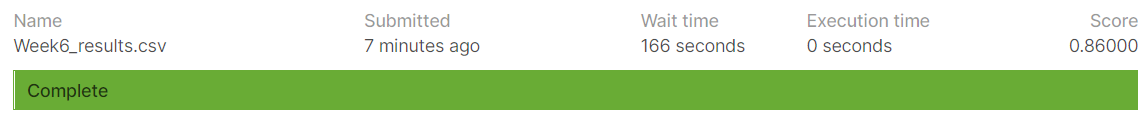

Результат соревнования показан выше. Результат можно было бы улучшить добрав еще положительных отзывов, но так как задача учебная, я не стал зацикливаться на максимизации оценки